# Analysis of Gross national income (GNI)

Imports and set magics:

In [141]:
# Importing API from DST, specifying the language
import pydst                          
Dst = pydst.Dst(lang='en')            
# Importing packages for data analysis 
import pandas as pd                   
import numpy as np                    
import matplotlib.pyplot as plt       
import ipywidgets as widgets             

# Autoreloading modules when code is run
%load_ext autoreload
%autoreload 2

# Local modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

**Read the  data** from DSTI. We want to analyze the table named NKN2 including the Danish gross national income  by transaction and price unit:

In [142]:
#In order to retrieve the dataset 'NKN2' from DST, we run the following code to extract the desided variables and shows the first and last three rows of the dataset
fuldt_dataset = Dst.get_data(table_id = 'NKN2',
                             variables = {'TRANSAKT':['B5GQD'], 
                                          'PRISENHED':['V'], 
                                          'SÆSON':['Y'],
                                          'TID':['*']})       

pd.concat([fuldt_dataset.head(3), fuldt_dataset.tail(3)])     

,TRANSAKT,PRISENHED,SÆSON,TID,INDHOLD
0,B.5*g Gross national income,Current prices,Seasonally adjusted,1990Q1,203986
1,B.5*g Gross national income,Current prices,Seasonally adjusted,1990Q2,209384
2,B.5*g Gross national income,Current prices,Seasonally adjusted,1990Q3,209650
117,B.5*g Gross national income,Current prices,Seasonally adjusted,2019Q2,595301
118,B.5*g Gross national income,Current prices,Seasonally adjusted,2019Q3,599325
119,B.5*g Gross national income,Current prices,Seasonally adjusted,2019Q4,604514


In [143]:
#We now remove redundant variables, so only time and GNI remain.
df1 = fuldt_dataset.drop(columns=['TRANSAKT', 'PRISENHED', 'SÆSON'], axis=1) 
df1.columns = ['Tid', 'GNI']                        
df1['GNI'].replace('..',np.nan, inplace=True)
df1.dropna(inplace=True)       
pd.concat([df1.head(3), df1.tail(3)])     

,Tid,GNI
0,1990Q1,203986
1,1990Q2,209384
2,1990Q3,209650
117,2019Q2,595301
118,2019Q3,599325
119,2019Q4,604514


Time and GNI is extracted as arrays. Empty cells are removed, converting the variable to a float type:

In [144]:
#Checking for empty cells, removing if empty cells                
df1['GNI'].replace('..',np.nan, inplace=True)
df1.dropna(inplace=True) 
pd.concat([df1.head(3), df1.tail(3)])     

,Tid,GNI
0,1990Q1,203986
1,1990Q2,209384
2,1990Q3,209650
117,2019Q2,595301
118,2019Q3,599325
119,2019Q4,604514


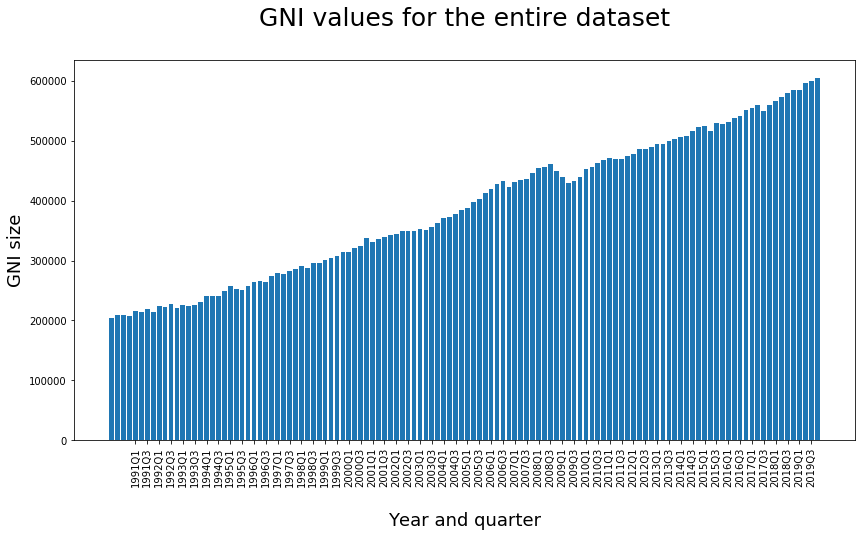

In [145]:
#Barplot of GNI over time
plt.figure(figsize=(14,7))
plt.xlabel('\nYear and quarter', size=18)           # Sets label on t variable
plt.ylabel('GNI size', size=18)                     # Sets label on GNI variable
plt.bar(df1['Tid'], df1['GNI'], label='GNI')                          # Plots GNI
plt.title('GNI values for the entire dataset\n', size=25)  # Sets title of the plot
plt.xticks(df1['Tid'][4:] , rotation='vertical')                # Makes time units appear on the x axis
plt.locator_params(axis='x', nbins=len(df1['Tid'][4:])/2) 
plt.show()

## Analyzing the dataset

**Now, we are interested at looking at the growth rate and descriptive statistics of the dataset.** Summarizing the data, we find:

In [146]:
df1['GNI'].describe()


count       120.000000
mean     387769.708333
std      117975.806792
min      203986.000000
25%      281706.750000
50%      386075.500000
75%      485622.000000
max      604514.000000
Name: GNI, dtype: float64

In the period from 1991 to 2019 Q3, we see that the mean for these observations are about 385 bill. DKK, while the minimum and maximum are, 210 bill. DKK and 588 bill. DKK., respectively. 

In order to be able to **explore the raw data**, we now plot the growth rate of GNI

In [147]:
#Calculating the growth rate
df1['Growth'] = df1['GNI'].pct_change()     


Visualization

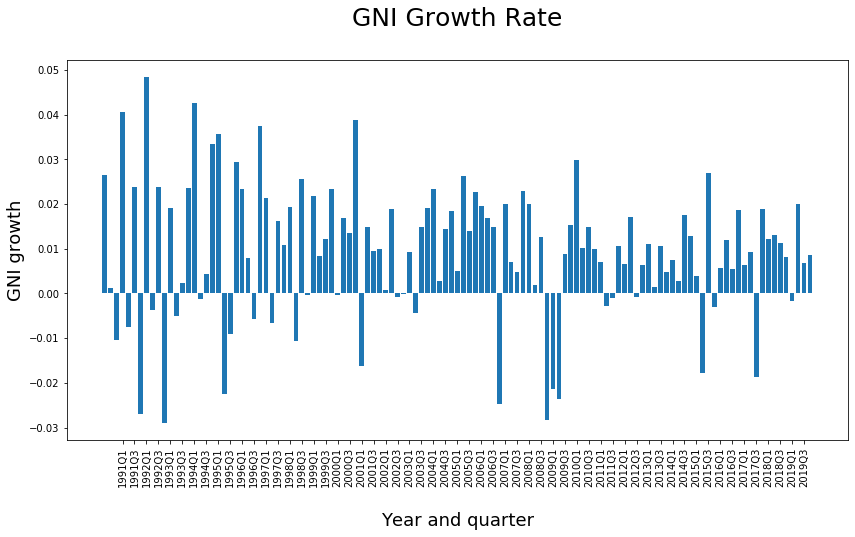

In [148]:

plt.figure(figsize=(14,7))
plt.xlabel('\nYear and quarter', size=18)          
plt.ylabel('GNI growth', size=18)                  
plt.bar(df1['Tid'], df1['Growth'], label='Growth of GNI')               
plt.title('GNI Growth Rate\n', size=25)  
plt.xticks(df1['Tid'][4:], rotation='vertical')       
plt.locator_params(axis='x', nbins=len(df1['Tid'][4:])/2) 

In the period from 1991 to 2019 Q3, we see that the mean for these observations are about 385 bill. DKK, while the minimum and maximum are, 210 bill. DKK and 588 bill. DKK., respectively. 

# Calculating moving averages

We now want to calculate the exponential moving averages of GNI in order to better capture the movement of the trend:

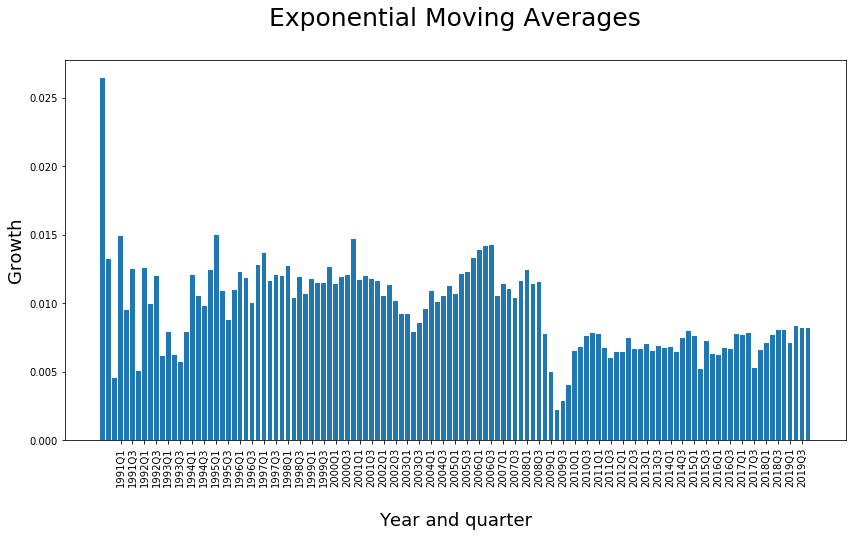

In [149]:
#df1['EMA']=df1['Growth'].ewm(span=20).mean().plot(style='k')
df1['EMA']=df1['Growth'].ewm(span=20).mean()


#Plotting Exponential Moving Averages
plt.figure(figsize=(14,7))
plt.xlabel('\nYear and quarter', size=18)          
plt.ylabel('Growth', size=18)                  
plt.bar(df1['Tid'], df1['EMA'], label='Growth of GNI')               
plt.title('Exponential Moving Averages\n', size=25)  
plt.xticks(df1['Tid'][4:], rotation='vertical')       
plt.locator_params(axis='x', nbins=len(df1['Tid'][4:])/2) 


Since he financial crisis in 2008, we haven’t been able to reach the same growth level as before. This is showed in the graph. It indicates clearly that the growth level have been steady but on a lower level


# Conclusion

In this assignment, we are showing how GNI have been evolving since 1991. The data is on quarterly basis. We have been using the “standard” packager and added the package “pyDST” to get data directly from DST. We see that GNI have been increasing and but the growth level haven’t reach the same height as before the financial crisis.  GNI can be considered as a better indicator, because BNI count also foreign income as well.  